# 참조링크

- Sleep detection git<br>
https://github.com/tahaemara/sleep-detection<br>
- [pytorch+opencv] 졸음 감지 프로그램 (sleepy eyes detector)<br>
https://ys-cs17.tistory.com/24<br>
- anaconda dlib 설치하기<br>
https://velog.io/@siyeon-hwang/anaconda-dlib-%EC%84%A4%EC%B9%98%ED%95%98%EA%B8%B0<br>
- Google Teachable Machine 활용 프로젝트 - 졸지마!<br>
https://ai-creator.tistory.com/26

# Preprocess

In [ ]:
!pip install helpers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from helpers import *
import matplotlib.pyplot as plt
import os, glob, cv2, random
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/multicampus/team_project2

/content/drive/MyDrive/multicampus/team_project2


In [ ]:
# !unzip -qq "eyes_project.zip"
# !unzip -qq "eyes_project (2).zip"

In [ ]:
X = np.load('eyes_project/x_train.npy').astype(np.float32)  # (2586, 26, 34, 1)
y = np.load('eyes_project/y_train.npy').astype(np.float32)  # (2586, 1)

In [ ]:
print(X.shape, y.shape)

(2327, 26, 34, 1) (2327, 1)


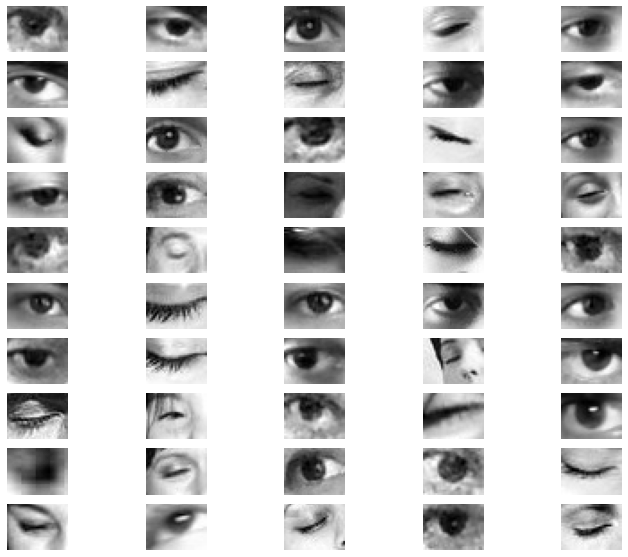

In [ ]:
# 내가 봤을때 왼쪽 눈
plt.figure(figsize=(12, 10))
for i in range(50):
    plt.subplot(10, 5, i+1)
    plt.axis('off')
    plt.imshow(X[i].reshape((26, 34)), cmap='gray')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


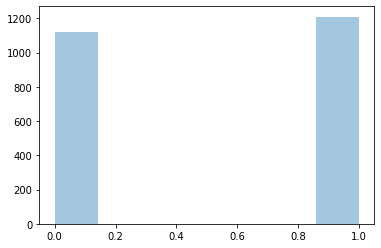

In [ ]:
sns.distplot(y, kde=False)

In [ ]:
n_total = len(X)
X_result = np.empty((n_total, 26, 34, 1))

for i, x in enumerate(X):
    img = x.reshape((26, 34, 1))
    
    X_result[i] = img

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_result, y, test_size=0.1)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

np.save('eyes_project/x_train.npy', x_train)
np.save('eyes_project/y_train.npy', y_train)
np.save('eyes_project/x_val.npy', x_val)
np.save('eyes_project/y_val.npy', y_val)

(2094, 26, 34, 1) (2094, 1)
(233, 26, 34, 1) (233, 1)


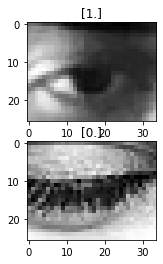

In [ ]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


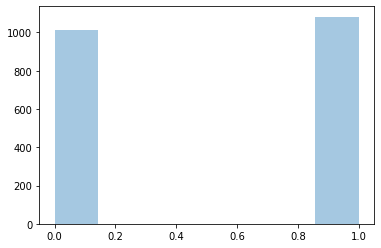

In [ ]:
sns.distplot(y_train, kde=False)

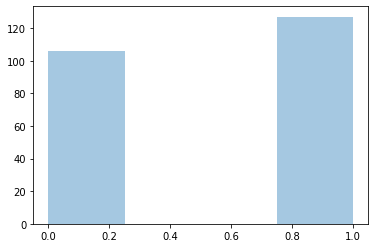

In [ ]:
sns.distplot(y_val, kde=False)

# Train

In [ ]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

In [ ]:
x_train = np.load('eyes_project/x_train.npy').astype(np.float32)
y_train = np.load('eyes_project/y_train.npy').astype(np.float32)
x_val = np.load('eyes_project/x_val.npy').astype(np.float32)
y_val = np.load('eyes_project/y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

In [ ]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

In [ ]:
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 34, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 17, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 8, 128)         73856 

In [ ]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

<ipython-input-27-303b1247d547>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.5501 - acc: 0.7182
Epoch 1: val_acc improved from -inf to 0.81974, saving model to models/2022_12_15_06_07_40.h5
66/66 [==============================] - 8s 105ms/step - loss: 0.5501 - acc: 0.7182 - val_loss: 0.4084 - val_acc: 0.8197 - lr: 0.0010
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.3045 - acc: 0.8768
Epoch 2: val_acc improved from 0.81974 to 0.90558, saving model to models/2022_12_15_06_07_40.h5
66/66 [==============================] - 6s 91ms/step - loss: 0.3045 - acc: 0.8768 - val_loss: 0.2293 - val_acc: 0.9056 - lr: 0.0010
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.1937 - acc: 0.9250
Epoch 3: val_acc improved from 0.90558 to 0.94850, saving model to models/2022_12_15_06_07_40.h5
66/66 [==============================] - 6s 93ms/step - loss: 0.1937 - acc: 0.9250 - val_loss: 0.1586 - val_acc: 0.9485 - lr: 0.0010
Epoch 4/50
66/66 [===========================

8/8 [==============================] - 0s 20ms/step
test acc: 0.9957081545064378


<ipython-input-28-2cdb396ae380>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred_logical = (y_pred > 0.5).astype(np.int)


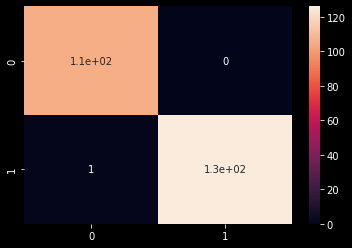

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/%s.h5' % (start_time))

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


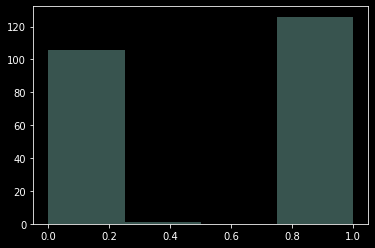

In [ ]:
ax = sns.distplot(y_pred, kde=False)

In [ ]:
import cv2, dlib
import numpy as np
from imutils import face_utils
from keras.models import load_model

In [ ]:
IMG_SIZE = (34, 26)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('eyes_project/shape_predictor_68_face_landmarks.dat')

model = load_model('eyes_project/2018_12_17_22_58_35.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 34, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 17, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 8, 128)         7385

In [ ]:
!pip install tensorflow

In [ ]:
# opencv test
import os
import glob
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread("eyes_project/test_img/test_close2.jpg", cv2.IMREAD_ANYCOLOR)
image = cv2.resize(image, (600, 800))

cv2_imshow(image)  # 코랩에선 cv2.imshow -> cv2_imshow 사용
cv2.waitKey()  # 아무키나 누르면 창 꺼짐
cv2.destroyAllWindows()

In [ ]:
def crop_eye(img, eye_points):
  x1, y1 = np.amin(eye_points, axis=0)
  x2, y2 = np.amax(eye_points, axis=0)
  cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

  w = (x2 - x1) * 1.2
  h = w * IMG_SIZE[1] / IMG_SIZE[0]

  margin_x, margin_y = w / 2, h / 2

  min_x, min_y = int(cx - margin_x), int(cy - margin_y)
  max_x, max_y = int(cx + margin_x), int(cy + margin_y)

  eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)

  eye_img = gray[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

  return eye_img, eye_rect

<ipython-input-55-cd2871c9b3ef>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


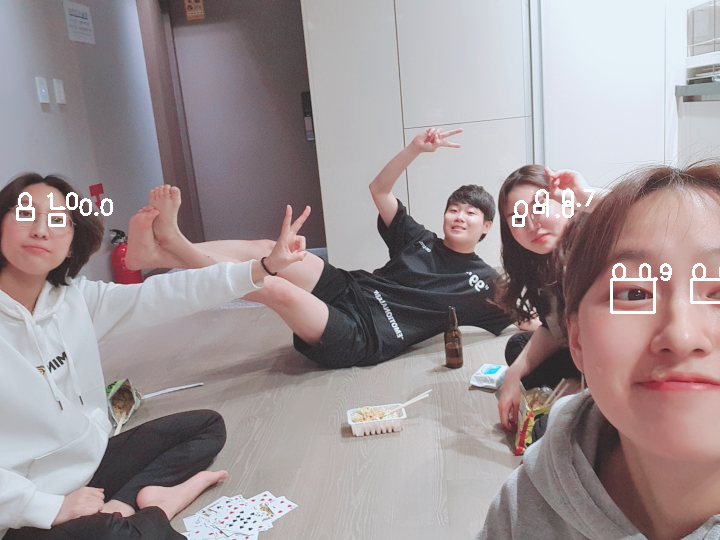

In [ ]:
# main
cap = cv2.VideoCapture('eyes_project/test_img/test_group.jpg')

while cap.isOpened():
  ret, img_ori = cap.read()

  if not ret:
    break

  img_ori = cv2.resize(img_ori, dsize=(0, 0), fx=0.5, fy=0.5)

  img = img_ori.copy()
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = detector(gray)

  for face in faces:
    shapes = predictor(gray, face)
    shapes = face_utils.shape_to_np(shapes)

    eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shapes[36:42])
    eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shapes[42:48])

    eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)
    eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
    eye_img_r = cv2.flip(eye_img_r, flipCode=1)

    cv2_imshow(eye_img_l)  # left
    cv2_imshow(eye_img_r)  # right

    eye_input_l = eye_img_l.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.
    eye_input_r = eye_img_r.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.

    pred_l = model.predict(eye_input_l)
    pred_r = model.predict(eye_input_r)

    # visualize
    state_l = 'O %.1f' if pred_l > 0.1 else '- %.1f'
    state_r = 'O %.1f' if pred_r > 0.1 else '- %.1f'

    state_l = state_l % pred_l
    state_r = state_r % pred_r

    cv2.rectangle(img, pt1=tuple(eye_rect_l[0:2]), pt2=tuple(eye_rect_l[2:4]), color=(255,255,255), thickness=2)
    cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(255,255,255), thickness=2)

    cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

  cv2_imshow(img)
  if cv2.waitKey(1) == ord('q'):
    break

<ipython-input-55-cd2871c9b3ef>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)


1/1 [==============================] - 0s 29ms/step


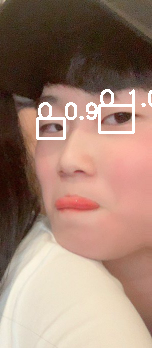

In [ ]:
# main
cap = cv2.VideoCapture('eyes_project/test_img/test_open.jpg')

while cap.isOpened():
  ret, img_ori = cap.read()

  if not ret:
    break

  img_ori = cv2.resize(img_ori, dsize=(0, 0), fx=0.5, fy=0.5)

  img = img_ori.copy()
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = detector(gray)

  for face in faces:
    shapes = predictor(gray, face)
    shapes = face_utils.shape_to_np(shapes)

    eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shapes[36:42])
    eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shapes[42:48])

    eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)
    eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
    eye_img_r = cv2.flip(eye_img_r, flipCode=1)

    cv2_imshow(eye_img_l)  # left
    cv2_imshow(eye_img_r)  # right

    eye_input_l = eye_img_l.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.
    eye_input_r = eye_img_r.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.

    pred_l = model.predict(eye_input_l)
    pred_r = model.predict(eye_input_r)

    # visualize
    state_l = 'O %.1f' if pred_l > 0.1 else '- %.1f'
    state_r = 'O %.1f' if pred_r > 0.1 else '- %.1f'

    state_l = state_l % pred_l
    state_r = state_r % pred_r

    cv2.rectangle(img, pt1=tuple(eye_rect_l[0:2]), pt2=tuple(eye_rect_l[2:4]), color=(255,255,255), thickness=2)
    cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(255,255,255), thickness=2)

    cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

  cv2_imshow(img)
  if cv2.waitKey(1) == ord('q'):
    break

<ipython-input-55-cd2871c9b3ef>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 31ms/step


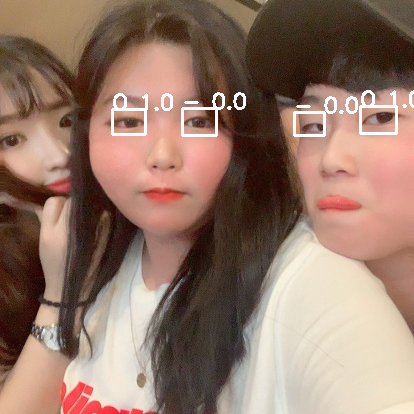

In [ ]:
# main
cap = cv2.VideoCapture('eyes_project/test_img/test_group2.jpg')

while cap.isOpened():
  ret, img_ori = cap.read()

  if not ret:
    break

  img_ori = cv2.resize(img_ori, dsize=(0, 0), fx=0.5, fy=0.5)

  img = img_ori.copy()
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = detector(gray)

  for face in faces:
    shapes = predictor(gray, face)
    shapes = face_utils.shape_to_np(shapes)

    eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shapes[36:42])
    eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shapes[42:48])

    eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)
    eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
    eye_img_r = cv2.flip(eye_img_r, flipCode=1)

    cv2_imshow(eye_img_l)  # left
    cv2_imshow(eye_img_r)  # right

    eye_input_l = eye_img_l.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.
    eye_input_r = eye_img_r.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.

    pred_l = model.predict(eye_input_l)
    pred_r = model.predict(eye_input_r)

    # visualize
    state_l = 'O %.1f' if pred_l > 0.1 else '- %.1f'
    state_r = 'O %.1f' if pred_r > 0.1 else '- %.1f'

    state_l = state_l % pred_l
    state_r = state_r % pred_r

    cv2.rectangle(img, pt1=tuple(eye_rect_l[0:2]), pt2=tuple(eye_rect_l[2:4]), color=(255,255,255), thickness=2)
    cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(255,255,255), thickness=2)

    cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

  cv2_imshow(img)
  if cv2.waitKey(1) == ord('q'):
    break

# 얼굴, 눈 인식

In [ ]:
# https://suy379.tistory.com/91

In [ ]:
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/multicampus/team_project2

/content/gdrive/MyDrive/multicampus/team_project2


In [ ]:
cascade_file = 'eyes_project/haarcascade_frontalface_alt.xml'
cascade = cv2.CascadeClassifier(cascade_file)

In [ ]:
img = cv2.imread('eyes_project/test_img/test_group.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face_list = cascade.detectMultiScale(gray, minSize=(50, 50))

In [ ]:
for (x, y, w, h) in face_list:
  color = (0, 0, 225)  # red
  pen_w = 3  # 선 굵기
  cv2.rectangle(img, (x, y), (x+w, y+h), color, thickness=pen_w)  # 정면얼굴에 사각형

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cascade_face_file = 'eyes_project/python-opencv-detect-master/haarcascade_frontalface_alt.xml'
cascade_face = cv2.CascadeClassifier(cascade_face_file)

cascade_eye_file = 'eyes_project/python-opencv-detect-master/haarcascade_eye.xml'
cascade_eye = cv2.CascadeClassifier(cascade_eye_file)

img = cv2.imread('eyes_project/test_img/test_group.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face_list = cascade_face.detectMultiScale(gray, minSize=(50, 50))

for (x, y, w, h) in face_list:
  color = (0, 0, 225)  # red
  pen_w = 3  # 선 굵기
  frame = cv2.rectangle(img, (x, y), (x+w, y+h), color, thickness=pen_w)  # 정면얼굴에 사각형
  face_range = gray[y:y+h,x:x+w]
  eye_list = cascade_eye.detectMultiScale(face_range)
  for (x2, y2, w2, h2) in eye_list:
    eye_center = (x + x2 + w2//2, y + y2 + h2//2)
    radius = int(round((w2 + h2)*0.25))
    frame = cv2.circle(frame, eye_center, radius, (255, 0, 0 ), 2)

from google.colab.patches import cv2_imshow
cv2_imshow(frame)
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# https://yunwoong.tistory.com/90

# recognize

In [ ]:
# https://yunwoong.tistory.com/84

Install

In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.0 MB 1.1 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.


Import Packages

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
 
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

Function

In [ ]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

Load Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/multicampus/team_project2/eyes_project

/content/gdrive/MyDrive/multicampus/team_project2/eyes_project


In [ ]:
image_path = 'test_img/test_group.jpg' 
image = cv2.imread(image_path)

Face detection

In [ ]:
with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
    results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Draw face detections of each face.
    if not results.detections:
        print("Face not found in image")
    else:
        print('Found {} faces.'.format(len(results.detections)))
        
        annotated_image = image.copy()
        
        for detection in results.detections:
            # print(mp_face_detection.get_key_point(detection, mp_face_detection.FaceKeyPoint.NOSE_TIP))
            mp_drawing.draw_detection(annotated_image, detection, bbox_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=7))
            
        plt_imshow(["Original", "Find Faces"], [image, annotated_image], figsize=(16,10))

Face Mesh

In [ ]:
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

In [ ]:
drawing_spec = mp_drawing.DrawingSpec(thickness=10, circle_radius=1)

In [ ]:
static_image_mode = True
max_num_faces = 10
refine_landmarks = True
min_detection_confidence = 0.5

In [ ]:
image_path = 'test_img/test_close.jpg' 
image = cv2.imread(image_path)

In [ ]:
with mp_face_mesh.FaceMesh(static_image_mode=static_image_mode, 
                           max_num_faces=max_num_faces, 
                           refine_landmarks=refine_landmarks, 
                           min_detection_confidence=min_detection_confidence) as face_mesh:
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    if not results.multi_face_landmarks:
        print("Face not found in image")
    else:
        print('Found {} faces.'.format(len(results.multi_face_landmarks)))
        
        annotated_image = image.copy()
        for face_landmarks in results.multi_face_landmarks:
            # print('face_landmarks:', face_landmarks)
            mp_drawing.draw_landmarks(image=annotated_image, 
                                      landmark_list=face_landmarks, 
                                      connections=mp_face_mesh.FACEMESH_TESSELATION,
                                      landmark_drawing_spec=drawing_spec, 
                                      connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
            mp_drawing.draw_landmarks(image=annotated_image,
                                      landmark_list=face_landmarks,
                                      connections=mp_face_mesh.FACEMESH_CONTOURS,
                                      landmark_drawing_spec=drawing_spec,
                                      connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())
            mp_drawing.draw_landmarks(image=annotated_image,
                                      landmark_list=face_landmarks,
                                      connections=mp_face_mesh.FACEMESH_IRISES,
                                      landmark_drawing_spec=None,
                                      connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_iris_connections_style())
            
        plt_imshow(["Original", "Find Faces"], [image, annotated_image], figsize=(16,10))


# mediapipe

In [ ]:
# https://kh-monib.medium.com/title-gaze-tracking-with-opencv-and-mediapipe-318ac0c9c2c3
# https://ys-cs17.tistory.com/24

In [ ]:
!pip install mediapipe

In [ ]:
import cv2
import mediapipe as mp

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/multicampus/team_project2/eyes_project

/content/gdrive/MyDrive/multicampus/team_project2/eyes_project


In [ ]:
# image_path = 'test_img/test_group.jpg' 
# image = cv2.imread(image_path)

# image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

In [ ]:
def getLandmarks(image_path):

  static_image_mode = True
  max_num_faces = 10
  refine_landmarks = True
  min_detection_confidence = 0.5  

  image = cv2.imread(image_path)

  with mp_face_mesh.FaceMesh(static_image_mode=static_image_mode, 
                           max_num_faces=max_num_faces, 
                           refine_landmarks=refine_landmarks, 
                           min_detection_confidence=min_detection_confidence) as face_mesh:
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

  landmarks = results.multi_face_landmarks[0].landmark

  return landmarks, results

In [ ]:
image_path = 'test_img/test_open.jpg'

In [ ]:
landmarks, results = getLandmarks(image_path)
image = cv2.imread(image_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
from google.colab.patches import cv2_imshow
def drawFaceMesh(image, results):
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            #         print('face landmarks', face_landmarks)
            mp_drawing.draw_landmarks(
                image=image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_CONTOURS,
                landmark_drawing_spec=drawing_spec,
                connection_drawing_spec=drawing_spec)
        cv2_imshow(image)

In [ ]:
drawFaceMesh(image, results)
drawFaceMesh(image_gray, results)

In [ ]:
# Crop the right eye region
def getRightEye(image, landmarks):
    eye_top = int(landmarks[263].y * image.shape[0])
    eye_left = int(landmarks[362].x * image.shape[1])
    eye_bottom = int(landmarks[374].y * image.shape[0])
    eye_right = int(landmarks[263].x * image.shape[1])
    right_eye = image[eye_top:eye_bottom, eye_left:eye_right]
    return right_eye

# Get the right eye coordinates on the actual -> to visualize the bbox
def getRightEyeRect(image, landmarks):
    eye_top = int(landmarks[257].y * image.shape[0])
    eye_left = int(landmarks[362].x * image.shape[1])
    eye_bottom = int(landmarks[374].y * image.shape[0])
    eye_right = int(landmarks[263].x * image.shape[1])

    cloned_image = image.copy()
    cropped_right_eye = cloned_image[eye_top:eye_bottom, eye_left:eye_right]
    h, w, _ = cropped_right_eye.shape

    x = eye_left
    y = eye_top
    return x, y, w, h


def getLeftEye(image, landmarks):
    eye_top = int(landmarks[159].y * image.shape[0])
    eye_left = int(landmarks[33].x * image.shape[1])
    eye_bottom = int(landmarks[145].y * image.shape[0])
    eye_right = int(landmarks[133].x * image.shape[1])
    left_eye = image[eye_top:eye_bottom, eye_left:eye_right]
    return left_eye


def getLeftEyeRect(image, landmarks):
    # eye_left landmarks (27, 23, 130, 133) ->? how to utilize z info
    eye_top = int(landmarks[159].y * image.shape[0])
    eye_left = int(landmarks[33].x * image.shape[1])
    eye_bottom = int(landmarks[145].y * image.shape[0])
    eye_right = int(landmarks[133].x * image.shape[1])

    cloned_image = image.copy()
    cropped_left_eye = cloned_image[eye_top:eye_bottom, eye_left:eye_right]
    h, w, _ = cropped_left_eye.shape

    x = eye_left
    y = eye_top
    return x, y, w, h

In [ ]:
# Visualize the Left and Region by drawing a rectangle on it on the actual image.
# RIGH EYE
rightEyeImg = getRightEye(image, landmarks)
rightEyeHeight, rightEyeWidth, _ = rightEyeImg.shape

xRightEye, yRightEye, rightEyeWidth, rightEyeHeight = getRightEyeRect(image, landmarks)
frame = cv2.rectangle(image, (xRightEye, yRightEye),
              (xRightEye + rightEyeWidth, yRightEye + rightEyeHeight), (200, 21, 36), 2)

# LEFT EYE
leftEyeImg = getLeftEye(image, landmarks)
leftEyeHeight, leftEyeWidth, _ = leftEyeImg.shape

xLeftEye, yLeftEye, leftEyeWidth, leftEyeHeight = getLeftEyeRect(image, landmarks)
frame = cv2.rectangle(image, (xLeftEye, yLeftEye),
              (xLeftEye + leftEyeWidth, yLeftEye + leftEyeHeight), (200, 21, 36), 2)

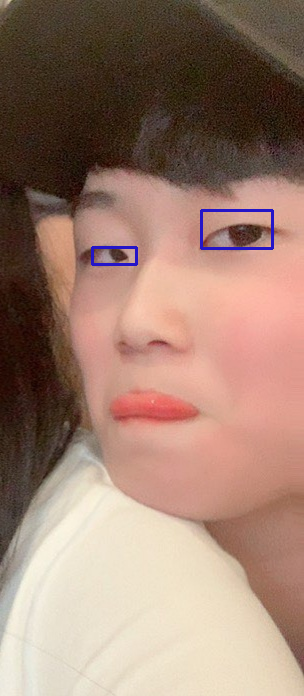

In [ ]:
cv2_imshow(frame)

In [ ]:
# leftEyeImg = getLeftEye(image, landmarks)
# cv2_imshow(leftEyeImg)
# cv2_imshow(rightEyeImg)
leftEyeImg
rightEyeImg

array([[[200,  21,  36],
        [200,  21,  36],
        [200,  21,  36],
        [200,  21,  36],
        [200,  21,  36],
        [200,  21,  36],
        [200,  21,  36]]], dtype=uint8)

In [ ]:
# predictor = dlib.shape_predictor('eyes_project/shape_predictor_68_face_landmarks.dat')
# model = load_model('eyes_project/2018_12_17_22_58_35.h5')
# model = load_model('models/2022_12_16_05_13_13.h5')
model = load_model('2018_12_17_22_58_35.h5')

In [ ]:
image.shape

(696, 304, 3)

In [ ]:
leftEyeImg = getLeftEye(image_gray, landmarks)
rightEyeImg = getRightEye(image_gray, landmarks)

In [ ]:
leftEyeImg.shape

(17, 44)

In [ ]:
# leftEyeImg = leftEyeImg.reshape(17, 44, 1)
left = cv2.resize(leftEyeImg, dsize=(34, 26))
right = cv2.resize(rightEyeImg, dsize=(34, 26))

In [ ]:
left = left.reshape(1, 26, 34, 1)
right = right.reshape(1, 26, 34, 1)

In [ ]:
left.shape

(1, 26, 34, 1)

In [ ]:
pred_l =  model.predict(left)
pred_r = model.predict(right)

1/1 [==============================] - 0s 16ms/step


In [ ]:
pred_l
pred_r

array([[1.]], dtype=float32)

In [ ]:
IMG_SIZE = (34, 26)

cv2_imshow(leftEyeImg)  # left
cv2_imshow(rightEyeImg)  # right


# eye_input_l = leftEyeImg.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.
# eye_input_r = rightEyeImg.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.

pred_l = model.predict(leftEyeImg)
pred_r = model.predict(rightEyeImg)

ValueError: ignored

In [ ]:
model.predict(leftEyeImg)

ValueError: ignored

In [ ]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

In [ ]:
x_train = np.load('x_train.npy').astype(np.float32)
y_train = np.load('y_train.npy').astype(np.float32)
x_val = np.load('x_val.npy').astype(np.float32)
y_val = np.load('y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2094, 26, 34, 1) (2094, 1)
(233, 26, 34, 1) (233, 1)


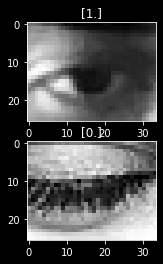

In [ ]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

In [ ]:
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 34, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 17, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 8, 128)         73856 

In [ ]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

8/8 [==============================] - 0s 20ms/step
test acc: 0.9957081545064378


<ipython-input-28-2cdb396ae380>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred_logical = (y_pred > 0.5).astype(np.int)


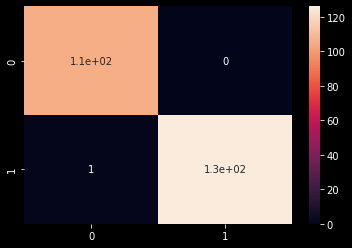

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/%s.h5' % (start_time))

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


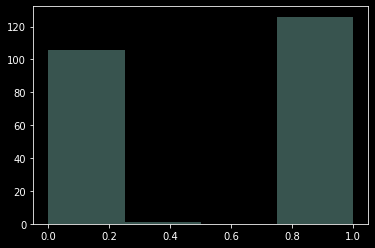

In [ ]:
ax = sns.distplot(y_pred, kde=False)

In [ ]:
import cv2, dlib
import numpy as np
from imutils import face_utils
from keras.models import load_model

In [ ]:
IMG_SIZE = (34, 26)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('eyes_project/shape_predictor_68_face_landmarks.dat')

model = load_model('eyes_project/2018_12_17_22_58_35.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 34, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 17, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 8, 128)         7385

In [ ]:
!pip install tensorflow

In [ ]:
# opencv test
import os
import glob
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread("eyes_project/test_img/test_close2.jpg", cv2.IMREAD_ANYCOLOR)
image = cv2.resize(image, (600, 800))

cv2_imshow(image)  # 코랩에선 cv2.imshow -> cv2_imshow 사용
cv2.waitKey()  # 아무키나 누르면 창 꺼짐
cv2.destroyAllWindows()

In [ ]:
def crop_eye(img, eye_points):
  x1, y1 = np.amin(eye_points, axis=0)
  x2, y2 = np.amax(eye_points, axis=0)
  cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

  w = (x2 - x1) * 1.2
  h = w * IMG_SIZE[1] / IMG_SIZE[0]

  margin_x, margin_y = w / 2, h / 2

  min_x, min_y = int(cx - margin_x), int(cy - margin_y)
  max_x, max_y = int(cx + margin_x), int(cy + margin_y)

  eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)

  eye_img = gray[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

  return eye_img, eye_rect

In [ ]:
# main
cap = cv2.VideoCapture('eyes_project/test_img/test_group.jpg')

while cap.isOpened():
  ret, img_ori = cap.read()

  if not ret:
    break

  img_ori = cv2.resize(img_ori, dsize=(0, 0), fx=0.5, fy=0.5)

  img = img_ori.copy()
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = detector(gray)

  for face in faces:
    shapes = predictor(gray, face)
    shapes = face_utils.shape_to_np(shapes)

    eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shapes[36:42])
    eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shapes[42:48])

    eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)
    eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
    eye_img_r = cv2.flip(eye_img_r, flipCode=1)

    cv2_imshow(eye_img_l)  # left
    cv2_imshow(eye_img_r)  # right

    eye_input_l = eye_img_l.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.
    eye_input_r = eye_img_r.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.

    pred_l = model.predict(eye_input_l)
    pred_r = model.predict(eye_input_r)

    # visualize
    state_l = 'O %.1f' if pred_l > 0.1 else '- %.1f'
    state_r = 'O %.1f' if pred_r > 0.1 else '- %.1f'

    state_l = state_l % pred_l
    state_r = state_r % pred_r

    cv2.rectangle(img, pt1=tuple(eye_rect_l[0:2]), pt2=tuple(eye_rect_l[2:4]), color=(255,255,255), thickness=2)
    cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(255,255,255), thickness=2)

    cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

  cv2_imshow(img)
  if cv2.waitKey(1) == ord('q'):
    break